# Overview

This project applies machine learning to mechanical systems that are monitored by sensory data. With machine learning operation of complicated equipment can help optimize efficiency and utilization of resources. Very often, the data is already being collected but as of right now, it is highly under utilized. 

In this project we'll look at a synthetic lubricant support system that supports a solar power plant in the desert. These systems supply lubricant to support systems within a power plant and require maintenance at specficly set alarm points. We'll use machine learning in a real-world application of predicting performance based on several external parameters. With this model, we can effectivy make decisions on equipment operation and scheduled maintenance.

## Generate the data

We will develop our own data set applying some basic laws of physics. In the end, this data will be representative of raw data that may be collected from sensors on actual equipment used to make every day operating decisions.

In this example, we'll consider the following sensory data:

1. Ambient Temperature
2. Accumulator Pressure
3. Pump Flow Rate

Why these 3 parameters? Our accumulator system has a positive pressure applied to it which results in slow leakage over time. This pressure is influenced by ambient temperature as desert extremes can vary to freezing and exceeding 100 F during the summer. The demand on the pump my vary throughout its operating which generally results in a different pressure differential between the sealed equipment and the accumulator. This affects the rate of leakage and how often the system must be serviced for maintenance. Knowing how these 3 parameters affected maintenance decisions, we'll look at preciting future performance based on past equipment data and ambient data that was collected.

### Generating Ambient Temperature Data

Solar plants are often in the desert of the Southwest USA. In this example, we'll be looking at ambient temperatures in Palm Springs for instance. It get's much cooler in the winter months which can affect performance of the system we are simulating. We'll start with this data to being developing our own dataset to experiment with.

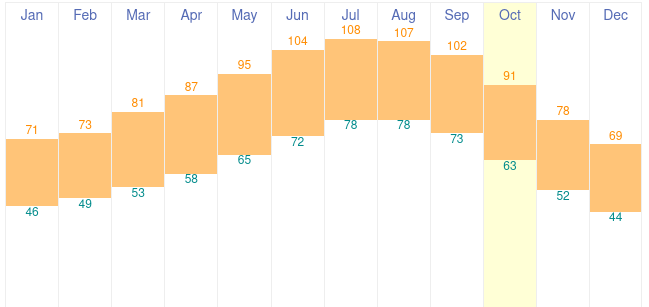



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
# Develop data over 2 yearswith temperatures recorded every 2 hours or 12 data points per day.
# Total of 8750 data points

readings_per_day = 12
days_in_month = 30
months = 24

time = np.arange(months * days_in_month * readings_per_day)
print(len(time))
# Create min and max arrays for monthly averages
min_temps = [46.0,49.0,53.0,58.0,65.0,72.0,78.0,78.0,73.0,63.0,52.0,44.0]
max_temps = [71.0,73.0,81.0,87.0, 95.0,104.0,108.0,107.0,102.0,91.0,78.0,69.0]

8640


In [2]:
def trend(time, slope=0):
    return slope * time

series = trend(time,slope=0)

# Now add the averages tempers to the reasonable seasonality and variation.
window = readings_per_day * days_in_month
for month in range(len(min_temps)):
    avg_temp = (min_temps[month]+max_temps[month])/2.0
    series[month*window:(month+1)*window] = avg_temp
    # Duplicate for 2nd year
    series[12*window:] = series[0:12*window]

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.8,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

temps = series + seasonality(time,period=12,amplitude=12,phase=6) + noise(time,noise_level=2,seed=15)


Text(0.5, 1.0, '5 Days of Data')

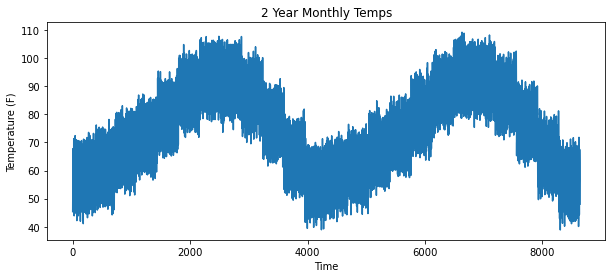

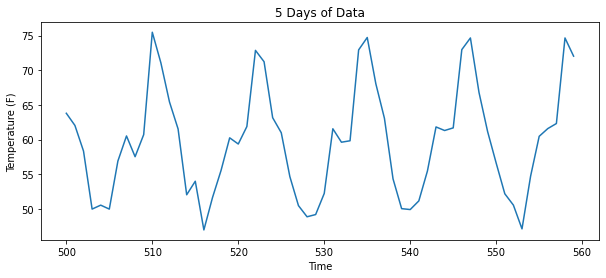

In [3]:
plt.figure(figsize=(10,4))
plt.plot(time,temps)
plt.ylabel("Temperature (F)")
plt.xlabel("Time")
plt.title("2 Year Monthly Temps")

plt.figure(figsize=(10,4))
plt.plot(time[500:560],temps[500:560])
plt.ylabel("Temperature (F)")
plt.xlabel("Time")
plt.title("5 Days of Data")

### Generate Pump Flow Rate Data¶

Next we'll generate pump flow rate data. Flow and pressure are related which will affect the pressure differential between the support system and equipment. This will change the leakage rate or consumption of the supporting fluid. We'll generate 3 different operating flow rates that will last a few months at a time. We'll scatter in 0 gpm indicating the equipment is in standby and not operating.

In [4]:
def gen_flow(time):
    flows = (0,5000,8000) # gpm
    series = trend(time,slope=0)
    index=0
    while(index<len(time)):
        duration = np.random.randint(low=2,high=4)
        x = np.random.randint(low=0,high=3)
        series[index:index+(duration*30*12)] = int(flows[x])
        index = duration*30*12 + index
    return series

flows = gen_flow(time)

Text(0.5, 1.0, 'Flow Rate of Pump over 2 Years')

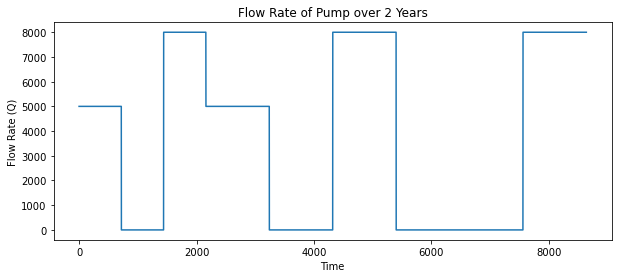

In [5]:
plt.figure(figsize=(10,4))
plt.plot(time,flows)
plt.ylabel("Flow Rate (Q)")
plt.xlabel("Time")
plt.title("Flow Rate of Pump over 2 Years")

### Generate Support System Pressure

Lastly we need to generate system pressure which will be dependent on the operation of the pump and the ambient temperatures. In practice, a high and low alarm is set to indentify when the system needs intervention. A high alarm indicates there is too much pressure in the system which may result in damage. A low alarm means, the system needst to be refilled. In this example, we'll give us a 25 psi operating window. At the initial fill of the this support system, we'll say the system was primed to 60 psi. The alarms are then at 70 psi and 40 psi for the low alarm. The system pressure will vary with ambient temperature and leakage will occur over time based on the operation of the equipment. We are generating this data but in the field, this informatino could be collected and fed into a neural network in order to predict future performane to schedule and monitor system maintenance.

In [6]:
psi = trend(time,0)
psi = psi + 60.0
print("Type psi[0]:",type(psi[0]))
leak_rate = {0:.002,5000:.042,8000:.083} #leak per data pt
print("Temp at time 0:",temps[0])

for index in range(len(time)):
    #print(leak_rate[flows[index]])
    #print("Index:",index)
    #print("Leak rate:",leak_rate[flows[index]])
    #print("Current psi:",psi[index])
    psi[index+1] = psi[index]*((temps[index+1]+459)/(temps[index]+459)) - leak_rate[flows[index]]
    #print("Next psi:", psi[index+1])
    if(psi[index+1]<35.0):
        psi[index+1]=60.0
    
    if(index==(len(time)-2)):
        break

Type psi[0]: <class 'numpy.float64'>
Temp at time 0: 45.37534303691291


Text(0.5, 1.0, 'System Pressure over 5 Days')

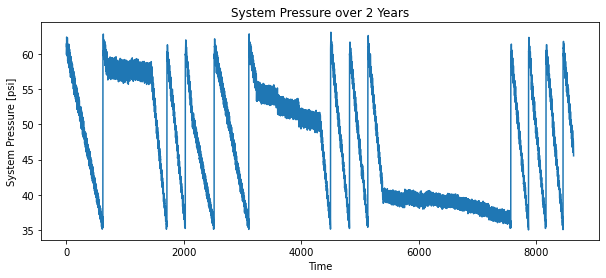

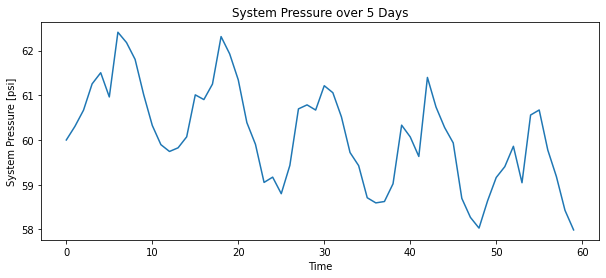

In [7]:
plt.figure(figsize=(10,4))
plt.plot(time,psi)
plt.ylabel("System Pressure [psi]")
plt.xlabel("Time")
plt.title("System Pressure over 2 Years")

plt.figure(figsize=(10,4))
plt.plot(time[:60],psi[:60])
plt.ylabel("System Pressure [psi]")
plt.xlabel("Time")
plt.title("System Pressure over 5 Days")

Now we've generated all the data to form out dataset that can be fed into a neural network. We'll make sure all the data is the same length and plot create subplots.

In [8]:
print("Length of time:",len(time))
print("Length of temps:",len(temps))
print("Length of flows:",len(flows))
print("Length of psi:",len(psi))

Length of time: 8640
Length of temps: 8640
Length of flows: 8640
Length of psi: 8640


Text(0, 0.5, 'System Pressure')

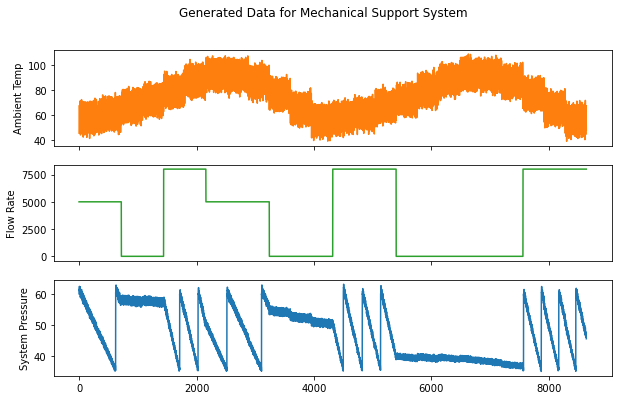

In [9]:
fig,axs = plt.subplots(3,sharex=True,figsize=(10,6))
fig.suptitle("Generated Data for Mechanical Support System")
axs[0].plot(time,temps,'tab:orange')
axs[0].set_ylabel("Ambient Temp")
axs[1].plot(time,flows,'tab:green')
axs[1].set_ylabel("Flow Rate")
axs[2].plot(time,psi)
axs[2].set_ylabel("System Pressure")

### Generate Dataframe

Now we'll combine all the series into a dataframe.

In [10]:
import pandas as pd

In [11]:
print(type(time))
df=pd.DataFrame({'Temp':temps,'Flow Rate':flows,'Pressure':psi})


<class 'numpy.ndarray'>


In [12]:
df.head(5)

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temp,8640.0,73.444772,15.078564,38.863788,61.533945,73.21094,85.004789,109.234050
Flow Rate,8640.0,3708.333333,3576.508219,0.000000,0.000000,5000.00000,8000.000000,8000.000000
Pressure,8640.0,47.283658,7.895763,35.008155,39.256275,47.58611,54.375593,63.092042


In [13]:
sys_csv_data = df.to_csv('../data/long_sys_data.csv',index=False) 

## Preparing the Data

First we'll split the data into 70%,20% and 10% for training,validation,testing.

In [14]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
print("Number of features:",num_features)
val_df.head()

Number of features: 3


,Temp,Flow Rate,Pressure
6048,68.973729,0,38.400605
6049,70.557262,0,38.513779
6050,71.721746,0,38.596470
6051,81.997915,0,39.341799
6052,79.605553,0,39.165824


Next we are going to normalize the data prior to feeding it into the model. We'll simplify the normalization by using the mean and standard deviation of the training data only to ensure there is no information of future data used. Alternatively we could use the moving average for the parameters.

In [16]:
# Standard deviation and mean for Temp and Pressure
train_temp_mean = train_df['Temp'].mean()
train_temp_std = train_df['Temp'].std()

train_psi_mean = train_df['Pressure'].mean()
train_psi_std = train_df['Pressure'].std()
# Flow will be devided by the max of 8000

# Normalize training data
train_df['Temp'] = (train_df['Temp'] - train_temp_mean) / train_temp_std
train_df['Flow Rate'] = train_df['Flow Rate'] / 8000
train_df['Pressure'] = (train_df['Pressure'] - train_psi_mean) / train_psi_std

# Normalize validation data
val_df['Temp'] = (val_df['Temp'] - train_temp_mean) / train_temp_std
val_df['Flow Rate'] = val_df['Flow Rate'] / 8000
val_df['Pressure'] = (val_df['Pressure'] - train_psi_mean) / train_psi_std

# Normalize test data
test_df['Temp'] = (test_df['Temp'] - train_temp_mean) / train_temp_std
test_df['Flow Rate'] = test_df['Flow Rate'] / 8000
test_df['Pressure'] = (test_df['Pressure'] - train_psi_mean) / train_psi_std

# Normaize Data Frame
df['Temp'] = (df['Temp'] - train_temp_mean) / train_temp_std
df['Flow Rate'] = df['Flow Rate'] / 8000
df['Pressure'] = (df['Pressure'] - train_psi_mean) / train_psi_std


<ipython-input-16-69cb2e794f80>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Temp'] = (train_df['Temp'] - train_temp_mean) / train_temp_std
<ipython-input-16-69cb2e794f80>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Flow Rate'] = train_df['Flow Rate'] / 8000
<ipython-input-16-69cb2e794f80>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [17]:
val_df.head()

,Temp,Flow Rate,Pressure
6048,-4.950040,0.0,-6.863063
6049,-4.942437,0.0,-6.860992
6050,-4.936846,0.0,-6.859479
6051,-4.887505,0.0,-6.845844
6052,-4.898992,0.0,-6.849063


In [18]:
train_df.head()

,Temp,Flow Rate,Pressure
0,-5.063347,0.625,-6.467899
1,-5.049370,0.625,-6.462332
2,-5.033036,0.625,-6.455701
3,-5.007549,0.625,-6.444933
4,-4.995738,0.625,-6.440359


In [19]:
train_ds = tf.data.Dataset.from_tensor_slices(train_df)
val_ds = tf.data.Dataset.from_tensor_slices(val_df)
test_ds = tf.data.Dataset.from_tensor_slices(test_df)

In [20]:
for element in train_ds:
    print(list(element))
    break

[<tf.Tensor: shape=(), dtype=float64, numpy=-5.063346594773069>, <tf.Tensor: shape=(), dtype=float64, numpy=0.625>, <tf.Tensor: shape=(), dtype=float64, numpy=-6.467898541004665>]


In [21]:
window_size = 24
train_ds = train_ds.window(window_size + 1, shift=1, drop_remainder=True)
for window in train_ds:
    print(list(window))
    break

[<tf.Tensor: shape=(3,), dtype=float64, numpy=array([-5.06334659,  0.625     , -6.46789854])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-5.04936998,  0.625     , -6.46233168])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-5.03303587,  0.625     , -6.45570139])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-5.00754868,  0.625     , -6.4449331 ])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-4.9957384 ,  0.625     , -6.44035928])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-5.0159824 ,  0.625     , -6.45027852])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-4.9556362 ,  0.625     , -6.42378755])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-4.9632777 ,  0.625     , -6.42800542])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-4.97685192,  0.625     , -6.43489725])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-5.0072794,  0.625    , -6.4493824])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-5.0334649

In [22]:
train_ds = train_ds.flat_map(lambda window: window.batch(window_size+1))

for window in train_ds:
    print(list(window))
    break

[<tf.Tensor: shape=(3,), dtype=float64, numpy=array([-5.06334659,  0.625     , -6.46789854])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-5.04936998,  0.625     , -6.46233168])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-5.03303587,  0.625     , -6.45570139])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-5.00754868,  0.625     , -6.4449331 ])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-4.9957384 ,  0.625     , -6.44035928])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-5.0159824 ,  0.625     , -6.45027852])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-4.9556362 ,  0.625     , -6.42378755])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-4.9632777 ,  0.625     , -6.42800542])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-4.97685192,  0.625     , -6.43489725])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-5.0072794,  0.625    , -6.4493824])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([-5.0334649

In [23]:
train_ds = train_ds.map(lambda window: (window[:-1], window[-1:,2][np.newaxis]))
for x,y in train_ds:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print(x.numpy().shape)
  print(y.numpy().shape)
  break

x =  [[-5.06334659  0.625      -6.46789854]
 [-5.04936998  0.625      -6.46233168]
 [-5.03303587  0.625      -6.45570139]
 [-5.00754868  0.625      -6.4449331 ]
 [-4.9957384   0.625      -6.44035928]
 [-5.0159824   0.625      -6.45027852]
 [-4.9556362   0.625      -6.42378755]
 [-4.9632777   0.625      -6.42800542]
 [-4.97685192  0.625      -6.43489725]
 [-5.0072794   0.625      -6.4493824 ]
 [-5.03346498  0.625      -6.46194718]
 [-5.04921718  0.625      -6.46980687]
 [-5.05372598  0.625      -6.47260361]
 [-5.04868524  0.625      -6.47110596]
 [-5.03696412  0.625      -6.46660886]
 [-4.99697418  0.625      -6.44942508]
 [-4.9995652   0.625      -6.45135583]
 [-4.98368003  0.625      -6.44500292]
 [-4.93856718  0.625      -6.42556112]
 [-4.95268913  0.625      -6.43265177]
 [-4.97476435  0.625      -6.44329633]
 [-5.01216121  0.625      -6.46078415]
 [-5.03037012  0.625      -6.46968774]
 [-5.06355076  0.625      -6.48526987]]
y =  [[-6.48311389]]
(24, 3)
(1, 1)


In [24]:
train_ds = train_ds.batch(12).prefetch(1)
for x,y in train_ds:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print(x.numpy().shape)
  print(y.numpy().shape)
  break

x =  [[[-5.06334659  0.625      -6.46789854]
  [-5.04936998  0.625      -6.46233168]
  [-5.03303587  0.625      -6.45570139]
  [-5.00754868  0.625      -6.4449331 ]
  [-4.9957384   0.625      -6.44035928]
  [-5.0159824   0.625      -6.45027852]
  [-4.9556362   0.625      -6.42378755]
  [-4.9632777   0.625      -6.42800542]
  [-4.97685192  0.625      -6.43489725]
  [-5.0072794   0.625      -6.4493824 ]
  [-5.03346498  0.625      -6.46194718]
  [-5.04921718  0.625      -6.46980687]
  [-5.05372598  0.625      -6.47260361]
  [-5.04868524  0.625      -6.47110596]
  [-5.03696412  0.625      -6.46660886]
  [-4.99697418  0.625      -6.44942508]
  [-4.9995652   0.625      -6.45135583]
  [-4.98368003  0.625      -6.44500292]
  [-4.93856718  0.625      -6.42556112]
  [-4.95268913  0.625      -6.43265177]
  [-4.97476435  0.625      -6.44329633]
  [-5.01216121  0.625      -6.46078415]
  [-5.03037012  0.625      -6.46968774]
  [-5.06355076  0.625      -6.48526987]]

 [[-5.04936998  0.625      -6.462

In [25]:
#print(train_ds)
train_ds.element_spec

(TensorSpec(shape=(None, None, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 1, None), dtype=tf.float64, name=None))

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(12,),
                           activation='relu'),
    tf.keras.layers.Dense(64, activation="relu"), 
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(train_ds,epochs=50,verbose=1)

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

502/502 [==============================] - 0s 959us/step - loss: 34.5089
Epoch 2/50
502/502 [==============================] - 1s 1ms/step - loss: 23.9307
Epoch 3/50
502/502 [==============================] - 1s 1ms/step - loss: 15.0694
Epoch 4/50
502/502 [==============================] - 1s 1ms/step - loss: 8.3060
Epoch 5/50
502/502 [==============================] - 1s 1ms/step - loss: 3.9169
Epoch 6/50
502/502 [==============================] - 1s 1ms/step - loss: 1.5966
Epoch 7/50
502/50

In [27]:
val_time = time[int(n*0.7):int(n*0.9)]

print(df.values[0:window_size].shape)

forecast=[]
for time in range(len(time) - window_size):
    forecast.append(model.predict(df.values[time:time + window_size][np.newaxis]))

(24, 3)


In [28]:
forecast = forecast[int(n*0.7):int(n*0.9)]
print(type(forecast))
print(len(forecast))
results = np.array(forecast)[:, 0,0]

<class 'list'>
1728


In [29]:
val_df.head()

,Temp,Flow Rate,Pressure
6048,-4.950040,0.0,-6.863063
6049,-4.942437,0.0,-6.860992
6050,-4.936846,0.0,-6.859479
6051,-4.887505,0.0,-6.845844
6052,-4.898992,0.0,-6.849063


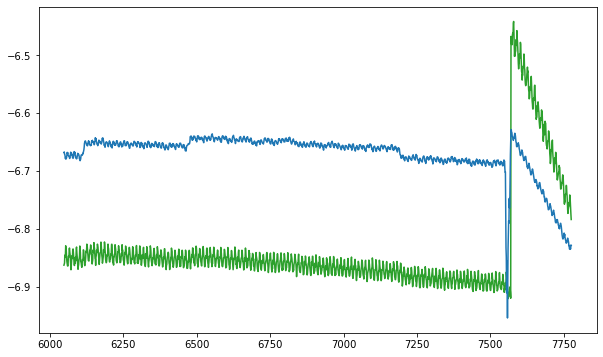

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(val_time,val_df['Pressure'],'tab:green')
plt.plot(val_time,results)

In [31]:
#print(len(val_df['Pressure']))
#print(type(val_df['Pressure'].va:-lues))
#print(val_df['Pressure'].values.shape)
#print(len(results))
#print(type(results))
#print(results.shape)
#print('........')
#print(results[:,0])
tf.keras.metrics.mean_absolute_error(val_df['Pressure'].values, results[:,0]).numpy()

0.19280437

In [32]:
results = (results * train_psi_std) + train_psi_mean
print(train_psi_mean)
print(train_psi_std)
print(results)

49.269776502050824
7.393191249509937
[[-0.03152466]
 [-0.02421188]
 [-0.05095673]
 ...
 [-1.2625427 ]
 [-1.2127495 ]
 [-1.2158241 ]]


In [33]:
print(psi[int(n*0.7):int(n*0.9)])

[38.40060513 38.51377874 38.59646965 ... 43.64896313 43.19467183
 42.71160145]


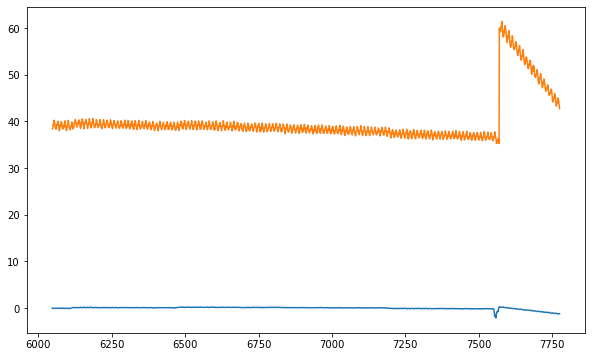

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(val_time,results)
plt.plot(val_time,psi[int(n*0.7):int(n*0.9)])
